In [228]:
import math
import numpy as np
from numpy import random
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [229]:
def z2x(z,typ,dist_param,corrmat):
    #z=np.array([[0.117786329536724,0.906056749773236,2.28732658561840,2.11617887466017,1.92616854758541,-1.17895895833063,1.86522403656920,-0.846142058945248]])
    nvar = len(typ[0])
    z=np.array([z])
    L = np.linalg.cholesky(corrmat)
    zcorr = np.matmul(z,L)
    u = norm.cdf(zcorr)                       
    x=np.zeros([1,nvar])                     
    for ivar in range(nvar):
        if   typ[0][ivar]==1:
            x[:,ivar]=dist_param[ivar,0] + dist_param[ivar,1]*zcorr[:,ivar]
        elif typ[0][ivar]==2:
            x[:,ivar]=math.exp(dist_param[ivar,0] + dist_param[ivar,1]*zcorr[:,ivar])
        elif typ[0][ivar]==3:x[:,ivar]=dist_param[ivar,1] + (dist_param[ivar,1] - dist_param[ivar,0])*u[:,ivar]
        elif typ[0][ivar]==4:x[:,ivar]=dist_param[ivar,0] - dist_param[ivar,1]*math.log(-math.log(u[:,ivar]))
        elif typ[0][ivar]==5:
            theta=1/(dist_param[ivar,1])
            x[:,ivar]= dist_param[ivar,0]*((-math.log(-(u[:,ivar]-1)))**theta)
        
    return x

In [230]:
def Fun(D,zrand,jtau,ndefect,mu,sd,typ,dist_param,corrmat):
    xrand = z2x(zrand,typ,dist_param,corrmat)
    wt= xrand[0][0]
    sigmau= xrand[0][1]
    P= xrand[0][2]
    d01=xrand[:,3:4+ndefect-1][0][0]
    l01=xrand[:,3+ndefect:4+ndefect+ndefect][0][0]
    gd1= xrand[:,3+ndefect+ndefect:3+ndefect+ndefect+ndefect][0][0]
    gl1= xrand[:,3+ndefect+ndefect+ndefect: 4+ndefect+ndefect+ndefect+ndefect-1][0][0]
    xi= xrand[:,-1][0]
             
              
    gll1= np.zeros([1,ndefect])[0][0]
    gb1= gll1
    gl0= gll1
    gb0= gll1
              
    for idefect in range(ndefect):
        d1= d01+gd1*jtau
        l1= l01+gl1*jtau       
        gll1= 0.8*wt - d1
        gb1=xi*(2*wt*sigmau/D)*(1-(d1/wt)*(1-math.exp((-0.157*l1/(math.sqrt(abs(D*(wt-d1))/2))))))-P
              
        if jtau > 1:
            d0= d01+gd1*(jtau - 1)
            l0= l01+gl1*(jtau - 1)
            gl0=0.8*wt - d0

            gb0=xi*(2*wt*sigmau/D)*(1-(d0/wt)*(1-math.exp((-0.157*l0/(math.sqrt(abs(D*(wt-d0))/2))))))-P
    
    if jtau==1:
        gl = gll1                                       
        gb = gb1                                            
    else:
        gl= gll1*gl0                                        
        gb= gb1*gb0                                          
        
    return [gl,gb]    

In [231]:
#Algorithm Parameters Requried 
N=300
p0=0.05
nt=round(N*p0) #15 
ns=math.ceil(1/p0-1) #19 
D=914 
jtau=10
ndefect=1
zrand=np.random.randn(300,(4+4*ndefect));#print("zrand",zrand)
z=zrand 
xrand=np.random.randn(300,(4+4*ndefect));#print("xrand",xrand)
n=len(xrand[0]) 
limit_state1=[] 
limit_state2=[]

#Paras Variable 
NumSam=300 
CondPro=0.05 
MaxTry=10

#Param Variable 
mu= np.array([[13.1400000000000,615.850000000000,10,2.62800000000000,50,0.400000000000000,5,1]]) 
sd= np.array([[0.197100000000000,18.4755000000000,0.300000000000000,0.525600000000000,10,0.200000000000000,2.50000000000000,0.100000000000000]]) 
typ=np.array([[1,2,4,1,1,5,2,2]]) 
dist_param= np.transpose(np.array([ [13.1400000000000,6.42255362976608,9.86498770189838,2.62800000000000,50,0.451625357017455,1.49786613677700,-0.00497516542658391],[0.197100000000000,0.0299932532886313,0.233909040370103,0.525600000000000,10,2.10134901124680,0.472380727077439,0.0997513451195927]])) 
corrmat=np.array([[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,0,0,0,1,0.500000000000000,0],[0,0,0,0,0,0.500000000000000,1,0],[0,0,0,0,0,0,0,1]])

In [232]:
g=[]
h=[]
for i in range(N):
    [g1,h1] = Fun(D,z[i,:],jtau,ndefect,mu,sd,typ,dist_param,corrmat)
    g.append(g1)
    h.append(h1)
g=[g]
h=[h]
g=np.array(g);#print(g,g.shape)
#print("\n")
h=np.array(h);#print(h,h.shape)

In [233]:
[gSort,index1]=[np.sort(g), np.argsort(g)];#print("gSort:",gSort,gSort.shape);print("\nindex1:",index1,index1.shape)
[hSort,index2]=[np.sort(h), np.argsort(h)];#print("hSort:",hSort,hSort.shape);print("\nindex2:",index2,index2.shape)
gRe = gSort
hRe = hSort


Z1 = z[index1,:][0];#print("\n Z1:",Z1,Z1.shape)
Z2 = z[index2,:][0];#print("\n Z2:",Z2,Z2.shape)
zRe1 = Z1
zRe2 = Z2


pfss1 = nt/N
pfss2 = nt/N

cdf =np.array([(N+1-np.array(range(N,0,-1)))/N]);#print("/n cdf",cdf,cdf.shape)


sigma1 = np.array([np.std(Z1[:nt,:],axis=0,ddof=1)])#;print("\nsigma1",sigma1,sigma1.shape)
sigma2 = np.array([np.std(Z2[:nt,:],axis=0,ddof=1)])#;print("\nsigma2",sigma2,sigma2.shape)

In [234]:
print("cdf=:",cdf,cdf.shape)
print("\nD=:",D)
print("\ng=:",g,g.shape)
print("\ngRe=:",gRe,gRe.shape)
print("\ngSort=:",gSort,gSort.shape)
print("\nh=:",h,h.shape)
print("\nhRe=:",hRe,hRe.shape)
print("\nhSort=:",hSort,hSort.shape)
print("\ni=:",i)
print("\nindex1=:",index1,index1.shape)
print("\nindex2=:",index2,index2.shape)
print("\njtau=:",jtau)
print("\nn=:",n)
print("\nN",N)
print("\nndefect=:",ndefect)
print("\nns=:",ns)
print("\nnt=:",nt)
print("\np0=:",p0)
print("\npfss1=:",pfss1)
print("\npfss2=:",pfss2)
print("\nxrand=:",xrand,xrand.shape)
print("\nz=:",z,z.shape)
print("\nZ1=:",Z1,Z1.shape)
print("\nZ2=:",Z2,Z2.shape)
print("\nzRe1=:",zRe1,zRe1.shape)


cdf=: [[0.00333333 0.00666667 0.01       0.01333333 0.01666667 0.02
  0.02333333 0.02666667 0.03       0.03333333 0.03666667 0.04
  0.04333333 0.04666667 0.05       0.05333333 0.05666667 0.06
  0.06333333 0.06666667 0.07       0.07333333 0.07666667 0.08
  0.08333333 0.08666667 0.09       0.09333333 0.09666667 0.1
  0.10333333 0.10666667 0.11       0.11333333 0.11666667 0.12
  0.12333333 0.12666667 0.13       0.13333333 0.13666667 0.14
  0.14333333 0.14666667 0.15       0.15333333 0.15666667 0.16
  0.16333333 0.16666667 0.17       0.17333333 0.17666667 0.18
  0.18333333 0.18666667 0.19       0.19333333 0.19666667 0.2
  0.20333333 0.20666667 0.21       0.21333333 0.21666667 0.22
  0.22333333 0.22666667 0.23       0.23333333 0.23666667 0.24
  0.24333333 0.24666667 0.25       0.25333333 0.25666667 0.26
  0.26333333 0.26666667 0.27       0.27333333 0.27666667 0.28
  0.28333333 0.28666667 0.29       0.29333333 0.29666667 0.3
  0.30333333 0.30666667 0.31       0.31333333 0.31666667 0.32
  0.3

In [235]:
stopFlag = 0                            
iterr = 1                                       
while(stopFlag == 0):
    w = Z1[0:nt,:];#print("\nw",w,w.shape)
    g = np.array([gSort[0,0:nt]]);#print("\ng",g,g.shape)
    iterr = iterr+1
    lenh = nt+1
    u=np.array([np.random.rand(n)]);#print("\nu:",u,u.shape)
    #newrow=[0,0,0,0,0,0,0,0,0,0,0,0]
    newrow=[0,0,0,0,0,0,0,0]
    for i in range(nt):
        seed=np.array([w[i,:]]);#print("\nseed:",seed,seed.shape)
        seed_g=g[0,i];#print("\nseed_g",seed_g,seed_g.shape)
        
        
        for j in range(ns):         # A Markov chain
            
            
            for k in  range(n):     # Component by component
                #Generate an candidate
                u = seed[0,k]+(2*random.rand()-1)*sigma1[0,k]
                #Calculate the acceptance probability
                pdf2 = math.exp(-0.5*np.power(seed[0,k],2));#print("pdf2:",pdf2)
                pdf1 = math.exp(-0.5*np.power(u,2));#print("pdf1:",pdf1)
                alpha = pdf1/pdf2;#print(alpha)
                #Accept u(k) with a probability of alpha
                if  alpha > np.random.rand():
                    newrow[k]=u
                else:
                    newrow[k]= seed[0,k]
                    
                    
            w = np.vstack([w, newrow])
            #print("\nw",w.shape)
            newrow=[0,0,0,0,0,0,0,0]
            #newrow=[0,0,0,0,0,0,0,0,0,0,0,0]
            [gTemp,theta] = Fun(D,w[lenh-1,:],jtau,ndefect,mu,sd,typ,dist_param,corrmat)    
            #Accept or Reject
            #print("\ngTemp:",gTemp)
            #print("\ngSort",gSort,gSort.shape)
            if gTemp <= gSort[0,nt]:
                g=np.array([np.append(g,gTemp)])#print("g",g,g.shape)#g[lenh-1] = gTemp
                seed = np.array([w[lenh-1,:]]);#print("\nseed:",seed,seed.shape)
                seed_g = g[0,lenh-1]#print("\nseed_g:",seed_g.shape)
            else:
                g=np.array([np.append(g,gTemp)])
                w[lenh-1,:] = seed
                    
            lenh=lenh+1
            #terminate the simulation of a Markov chain
            if lenh>N:break
        if lenh>N:break
    #print("w:",w,w.shape)
    #print("\ng:",g,g.shape)
    
    #Sort samples and LSF values
    [gSort,index]=[np.sort(g), np.argsort(g)]#;print("\ngSort:",gSort,gSort.shape);print("\nindex:",index,index.shape)
    Z1 = w[index-1,:][0]#;print("\nZ1:",Z1,Z1.shape)
    #Record the calculated results
    gRe = np.array([np.append(gSort,gRe[0,nt:])])#;print("\ngRe:",gRe,gRe.shape)
    cdf = np.array([np.append(np.array([(N+1-np.array(range(N,0,-1)))/N*(nt/N)**(iterr-1)]),np.array([cdf[0,nt:]]))])#;print("\ncdf:",cdf,cdf.shape)
    zRe1=np.concatenate((Z1, zRe1[nt:,:]), axis=0)#;print("zRe1:",zRe1,zRe1.shape)
    
    #print("g:\n",g)
    #print("g[0]",g[0],g[0].shape)
    #print(len([val for val in g[0] if val < 0]))
    if iterr >= MaxTry or  gSort[0,nt] <= 0:
        pfss1 = pfss1*(len([val for val in g[0] if val < 0])/N)
        stopFlag = 1
        limit_state1=limit_state1+[pfss1]
        break
    else:
        pfss1 = pfss1*(nt/N)
        limit_state1=limit_state1+[pfss1]
    #limit_state1=limit_state1+[pfss1]

limit_state1=np.array(limit_state1);print("limit_state1:\n",limit_state1,limit_state1.shape)
xaxis=np.array(range(1,len(limit_state1)+1))#;print(xaxis,xaxis.shape)

limit_state1:
 [0.0165] (1,)


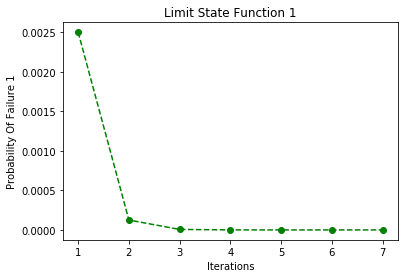

In [42]:
plt.plot(xaxis,limit_state1,'go--')
plt.xlabel("Iterations")
plt.ylabel("Probability Of Failure 1")
plt.title("Limit State Function 1")
plt.show()

In [59]:
stopFlag = 0                            
iterr = 1                                       
while(stopFlag == 0):
    w = Z2[0:nt,:];#print("\nw",w,w.shape)
    h = np.array([hSort[0,0:nt]]);#print("\ng",g,g.shape)
    iterr = iterr+1
    lenh = nt+1
    u=np.array([np.random.rand(n)]);#print("\nu:",u,u.shape)
    newrow=[0,0,0,0,0,0,0,0]
    for i in range(nt):
        seed=np.array([w[i,:]]);#print("\nseed:",seed,seed.shape)
        seed_h=h[0,i];#print("\nseed_g",seed_g,seed_g.shape)
        
        
        for j in range(ns):         # A Markov chain
            
            
            for k in  range(n):     # Component by component
                #Generate an candidate
                u = seed[0,k]+(2*random.rand()-1)*sigma1[0,k]
                #Calculate the acceptance probability
                pdf2 = math.exp(-0.5*np.power(seed[0,k],2));#print("pdf2:",pdf2)
                pdf1 = math.exp(-0.5*np.power(u,2));#print("pdf1:",pdf1)
                alpha = pdf1/pdf2;#print(alpha)
                #Accept u(k) with a probability of alpha
                if  alpha > np.random.rand():
                    newrow[k]=u
                else:
                    newrow[k]= seed[0,k]
                    
                    
            w = np.vstack([w, newrow])
            #print("\nw",w.shape)
            newrow=[0,0,0,0,0,0,0,0]
            [gTemp,theta] = Fun(D,w[lenh-1,:],jtau,ndefect,mu,sd,typ,dist_param,corrmat)    
            #Accept or Reject
            #print("\ngTemp:",gTemp)
            #print("\ngSort",gSort,gSort.shape)
            if theta <= hSort[0,nt]:
                h=np.array([np.append(h,theta)])#print("g",g,g.shape)#g[lenh-1] = gTemp
                seed = np.array([w[lenh-1,:]]);#print("\nseed:",seed,seed.shape)
                seed_h = h[0,lenh-1]#print("\nseed_g:",seed_g.shape)
            else:
                h=np.array([np.append(h,theta)])
                w[lenh-1,:] = seed
                    
            lenh=lenh+1
            #terminate the simulation of a Markov chain
            if lenh>N:break
        if lenh>N:break
    #print("w:",w,w.shape)
    #print("\ng:",g,g.shape)
    
    #Sort samples and LSF values
    [hSort,index]=[np.sort(h), np.argsort(h)]#;print("\ngSort:",gSort,gSort.shape);print("\nindex:",index,index.shape)
    Z2 = w[index-1,:][0]#;print("\nZ1:",Z1,Z1.shape)
    #Record the calculated results
    hRe = np.array([np.append(theta,hRe[0,nt:])])#;print("\ngRe:",gRe,gRe.shape)
    cdf = np.array([np.append(np.array([(N+1-np.array(range(N,0,-1)))/N*(nt/N)**(iterr-1)]),np.array([cdf[0,nt:]]))])#;print("\ncdf:",cdf,cdf.shape)
    zRe2=np.concatenate((Z2, zRe2[nt:,:]), axis=0)#;print("zRe1:",zRe1,zRe1.shape)
    
    if iterr >= MaxTry or  hSort[0,nt] <= 0:
        pfss2 = pfss2*(len([val for val in h[0] if val < 0])/N)
        stopFlag = 1
        break
    else:pfss2 = pfss2*(nt/N)
    limit_state2=limit_state2+[pfss2]

limit_state2=np.array(limit_state2);print("limit_state2:\n",limit_state2,limit_state2.shape)
xaxiss=np.array(range(1,len(limit_state2)+1))#;print(xaxiss,xaxiss.shape)

limit_state2:
 [0.0025] (1,)


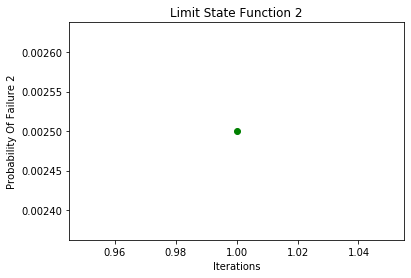

In [60]:
plt.plot(xaxiss,limit_state2,'go--')
plt.xlabel("Iterations")
plt.ylabel("Probability Of Failure 2")
plt.title("Limit State Function 2")
plt.show()

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

In [20]:
#Algorithm Parameters Requried
N=300            
p0=0.05             
nt=round(N*p0)        #15
ns=math.ceil(1/p0-1)  #19
D=914
jtau=1                                  
ndefect=2  
zrand=np.random.randn(300,(4+4*ndefect))  
z=zrand
xrand=np.random.randn(300,(4+4*ndefect))  
n=len(xrand[0])
limit_state1=[]
limit_state2=[]

#Paras Variable
NumSam=300
CondPro=0.05
MaxTry=10


#Param Variable
mu= np.array([[13.1400000000000,615.850000000000,10,2.62800000000000,2.62800000000000,50,50,0.400000000000000,0.400000000000000,5,5,1]])
sd= np.array([[0.197100000000000,18.4755000000000,0.300000000000000,0.525600000000000,0.525600000000000,10,10,0.200000000000000,0.200000000000000,2.50000000000000,2.50000000000000,0.100000000000000]])
typ=np.array([[1,2,4,1,1,1,1,5,5,2,2,2]])
dist_param= np.transpose(np.array([ [13.1400000000000,6.42255362976608,9.86498770189838,2.62800000000000,2.62800000000000,50,50,0.451625357017455,0.451625357017455,1.49786613677700,1.49786613677700,-0.00497516542658391],[0.197100000000000,0.0299932532886313,0.233909040370103,0.525600000000000,0.525600000000000,10,10,2.10134901124680,2.10134901124680,0.472380727077439,0.472380727077439,0.0997513451195927]]))
corrmat=np.array([[1,0,0,0,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,0,0,0,0,0],[0,0,0,0,0,1,0,0.500000000000000,0,0,0,0],[0,0,0,0,0,0,1,0,0.500000000000000,0,0,0],[0,0,0,0,0,0.500000000000000,0,1,0,0,0,0],[0,0,0,0,0,0,0.500000000000000,0,1,0,0,0],[0,0,0,0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,0,0,0,0,1]])
